# Task

Use dummy data to *maximize revenue from direct marketing campaigns.*

Imports

In [461]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import seaborn as sns
import xgboost as xgb
# roc curve and auc
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    classification_report,
    precision_recall_curve,
    PrecisionRecallDisplay
)

# Functions

In [462]:
def evaluate_models(clf_list, X_train, y_train):
    """
    a function that evalute a list of classifiers
    
    Input:
       *clf_list: list of tuples containing the classifier and its name.
       *X_train: an array with the training data
       *y_train: an array with the target data

    Output:
    type: dataframe
    """
    scores = defaultdict(list)
    for i, (clf, name) in enumerate(clf_list):
        clf.fit(X_train, y_train)
        try:
            y_prob = clf.predict_proba(X_test)
        except:
            print('model is not probabilistic')
            y_prob=np.zeros(shape=(len(y_pred),2))
        y_pred = clf.predict(X_test)
        scores["Classifier"].append(name)

        for metric in [brier_score_loss, log_loss, roc_auc_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[score_name].append(metric(y_test, y_prob[:, 1]))

        for metric in [accuracy_score, precision_score, recall_score, f1_score]:
            score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
            scores[score_name].append(metric(y_test, y_pred))

        score_df = pd.DataFrame(scores).set_index("Classifier")
        score_df.round(decimals=3)

    return score_df

def confusion_matrix_plot(y_test, y_pred):

    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

def plot_roc_PR_curve(model,y_test,y_proba, ax=None):
    model_name =type(model).__name__
    if ax is None:
       fig, ax = plt.subplots(1,2, figsize=(22,7))
    ns_probs = [0 for _ in range(len(y_test))]
    # calculate scores
    lr_auc = roc_auc_score(y_test, y_proba)
    # summarize scores
    print(model_name,': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr,_ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, thresholds = roc_curve(y_test, y_proba)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(lr_tpr * (1-lr_fpr))
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    precision, recall, thr = precision_recall_curve(y_test, y_proba)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix2 = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thr[ix2], fscore[ix2]))
    # plot the roc curve for the model
    ax[0].plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax[0].plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    ax[0].scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='red', label='Best according to ROC')
    index = np.argmin(np.abs(thresholds-thr[ix2]))
    ax[0].scatter(lr_fpr[index], lr_tpr[index], marker='o', color='black', label='Best according to PR')

    # axis labels
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    # show the legend
    ax[0].legend()
    ax[0].set_title('ROC curve')

    PrecisionRecallDisplay(precision=precision, recall=recall).plot(ax=ax[1],label=model_name)
    ax[1].scatter(recall[ix2], precision[ix2], marker='o', color='black', label='Best according to PR')
    index = np.argmin(np.abs(thr-thresholds[ix]))
    ax[1].scatter(recall[index], precision[index], marker='o', color='red', label='Best according to ROC')
    ax[1].legend()
    ax[0].set_title('PR curve')
    return thresholds[ix], thr[ix2]

def evaluation_report(model,X_test,y_test,best='ROC'):

    y_proba = model.predict_proba(X_test)[:,1]
    best_th_roc, best_th_pr = plot_roc_PR_curve(model, y_test, y_proba)
    plt.show()

    if best == 'ROC':
        best_th = best_th_roc
    else:
        best_th = best_th_pr
    y_pred = (y_proba>= best_th).astype('int')
    print(classification_report(y_test, y_pred))
    confusion_matrix_plot(y_test, y_pred)
    return y_pred

def evaluation_report_all(models,X_test,y_test):
    fig, ax = plt.subplots(1,2, figsize=(22,7))
    for model in models:
        y_proba = model.predict_proba(X_test)[:,1]
        best_th_roc, best_th_pr = plot_roc_PR_curve(model, y_test, y_proba, ax)
    
def remove_outliers(data,per=90):
    perc= np.percentile(data,per)
    data[data>perc]=perc
    return data

# Data cleaning

For the analysis, several tables are available:

* Social-demographical data (age, gender, tenure in a bank)
* Products owned + actual volumes (current account, saving account, mutual funds, overdraft,
credit card, consumer loan)
* Inflow/outflow on C/A, aggregated card turnover (monthly average over past 3 months)
* For 60 % of clients actual sales + revenues from these are available (training set)

read data

In [476]:
xls = pd.ExcelFile('Task_Data_Scientist_Dataset.xlsx')
Soc_Dem = pd.read_excel(xls, 'Soc_Dem')
Products_ActBalance = pd.read_excel(xls, 'Products_ActBalance')
Inflow_Outflow = pd.read_excel(xls, 'Inflow_Outflow')
Sales_Revenues = pd.read_excel(xls, 'Sales_Revenues')

Missing data handling

In [477]:
#It seams that the nan data in this Products_ActBalance informs whether the client has a an account or no,
#Since there is no 0 in this count columns, we replace nans with 0. 
#We treat the actualBal differently: we have zeros in those columns, 
#we add an insignificant value compared to the distribution (1 euro), and than the nans are replaced with 0 to distinguish it.
remove_nans = True
if remove_nans:
    Products_ActBalance = pd.concat([Products_ActBalance.filter(regex='Count').fillna(0),
                                    (Products_ActBalance.filter(regex='ActBal')+1).fillna(0),
                                    Products_ActBalance.Client],
                                    axis=1)

    # fill in the 3 missing gender rows with the majority gender
    Soc_Dem = Soc_Dem.fillna('M')

    #the other tables are complete

Convert Cateegorical data into numerical

In [478]:
Soc_Dem['Sex'] = Soc_Dem['Sex'].astype('category').cat.codes

#not all models accepts categorical, so we convert for all the tried models

Remove outliers

In [479]:
# merge tables
all_features = Soc_Dem.merge(Products_ActBalance,on=['Client'], how='inner')
all_features = all_features.merge(Inflow_Outflow,on=['Client'], how='inner')

#Remove outliers
do_remove_outliers = True 
### DO NOT REMOVE OUTLIERS FOR COUNTS DATA (NUMBER OF ACCOUNTS AND NUMBER OF TRANSACTIONS)
### Remove for volume and actbal data (euros unit features), using the capping method
if do_remove_outliers:
    all_features_NOoutliers = pd.DataFrame(columns=all_features.columns)
    for feature in all_features.columns:
        
        data = all_features[feature]
        if ('Volum' in feature) | ('ActBal' in feature):       #skip count features
            data = remove_outliers(data, per=95) 

        all_features_NOoutliers[feature] = data
    all_features = all_features_NOoutliers


Feature engineering

In [480]:
def generation_category(age):
    if age<20:
        #category minor
        gen =  0
    elif age<31:
        gen = 1
    elif age<45:
        gen=2
    elif age<65:
        gen=3
    else:
        #retired
        gen=4
    return gen

all_features['gen'] = all_features['Age'].apply(generation_category)

# put income into buckets: VolumeCred is the income?
# Since this table is highly correlated, we can select few features: VolumeCred
def income_bucket(VolumeCred):
    if VolumeCred<50:
        buck=0
        #these clients might have a second account with another bank
    elif VolumeCred<1500:
        #let'say minimum wage is 1500, people that has lower Volum Cred they might 
        # not recieve their salary with a different account or they don't work
        buck = 1
    elif VolumeCred<3000:
        buck = 2
    elif VolumeCred<5000:
        buck = 3
    elif VolumeCred<8000:
        buck = 4
    else:
        buck = 5
    return buck
    
all_features['income_bucket'] = all_features.VolumeCred.apply(income_bucket)
#==> from the corr matrix income bucket is correlated with all the variables in the table, might as well remove all the table and keep income_bucket

Create the training set

In [481]:
# training and test data are the client id found in Sales_Revenues
# validation data from which to answer the questions are the remaining ids
# drop counts
all_features = all_features[all_features.columns.drop(list(all_features.filter(regex='Count_CA')))]
#X = X[X.columns.drop(list(X.filter(regex='Transac')))]
#X = X[X.columns.drop(list(X.filter(regex='Vol')))]
features_name = all_features.columns

X = all_features[all_features.Client.isin(Sales_Revenues.Client)].reset_index(drop=True)
y = Sales_Revenues[Sales_Revenues.Client.isin(X.Client)].reset_index(drop=True)
eval = all_features[~all_features.Client.isin(X.Client)]

#remove ids
X.drop('Client', axis=1, inplace=True)

### Data visualization

'\n==>\nMutual fund is the least revenue source out of the three revenues\nclients are more susptible to accept Customer loan, and having alomst the same revenue as credit card per sale.add()\nwe will probably call more on the offer of Customer loan, then Credit card, then Mututal fund\n'

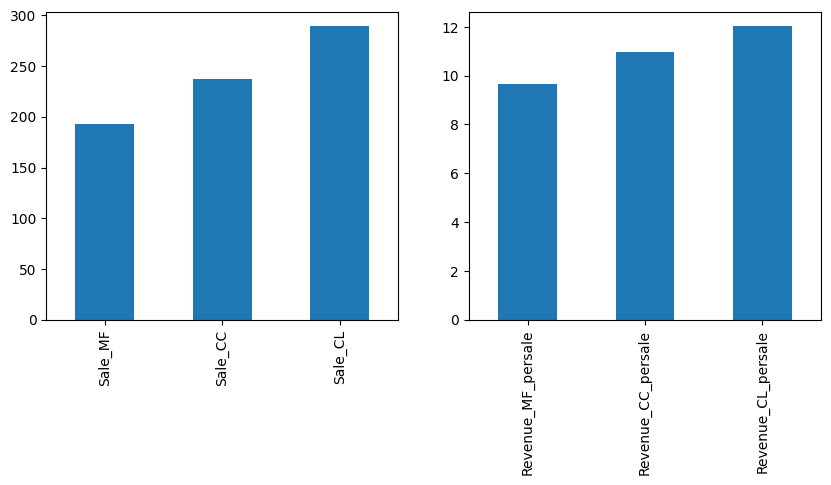

In [469]:
#target
fig, ax = plt.subplots(1,2,figsize=(10,4))
y[['Sale_MF','Sale_CC', 'Sale_CL']].sum().plot.bar(ax=ax[0])
y[['Revenue_MF_persale','Revenue_CC_persale','Revenue_CL_persale']] = y[['Revenue_MF','Revenue_CC','Revenue_CL']].sum().values/y[['Sale_MF','Sale_CC', 'Sale_CL']].sum().values
y[['Revenue_MF_persale','Revenue_CC_persale','Revenue_CL_persale']].iloc[0].plot.bar(ax=ax[1])

"""
==>
Mutual fund is the least revenue source out of the three revenues
clients are more susptible to accept Customer loan, and having alomst the same revenue as credit card per sale.add()
we will probably call more on the offer of Customer loan, then Credit card, then Mututal fund
"""


'\nopposite observation in the features compared to the target, in the data we have more customers with mutula funds, while the target variable is less susptible to buy a mutual fund\ncustomers that already have a loan, do not tend to go for another loan? the assumption is coming fron the distribution of Count_CL that is concentrating at only 1CL, max rarely 2CL.\ncustomers tend to have mutual funds with a median of 2 ==> maybe the ones that have only 1 MF tends to accept the MF offer.\n'

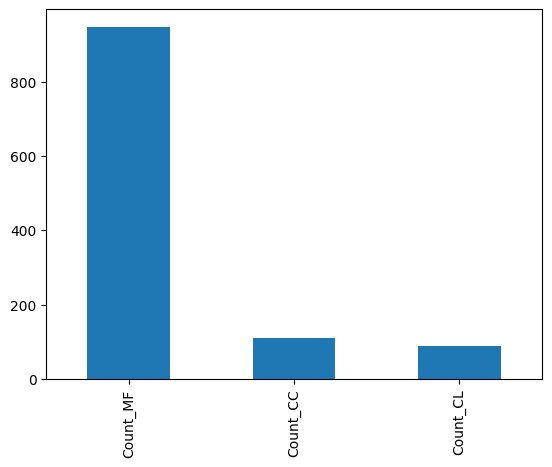

In [76]:
X[['Count_MF','Count_CC', 'Count_CL']].sum().plot.bar()
"""
opposite observation in the features compared to the target, in the data we have more customers with mutula funds, while the target variable is less susptible to buy a mutual fund
customers that already have a loan, do not tend to go for another loan? the assumption is coming fron the distribution of Count_CL that is concentrating at only 1CL, max rarely 2CL.
customers tend to have mutual funds with a median of 2 ==> maybe the ones that have only 1 MF tends to accept the MF offer.
"""

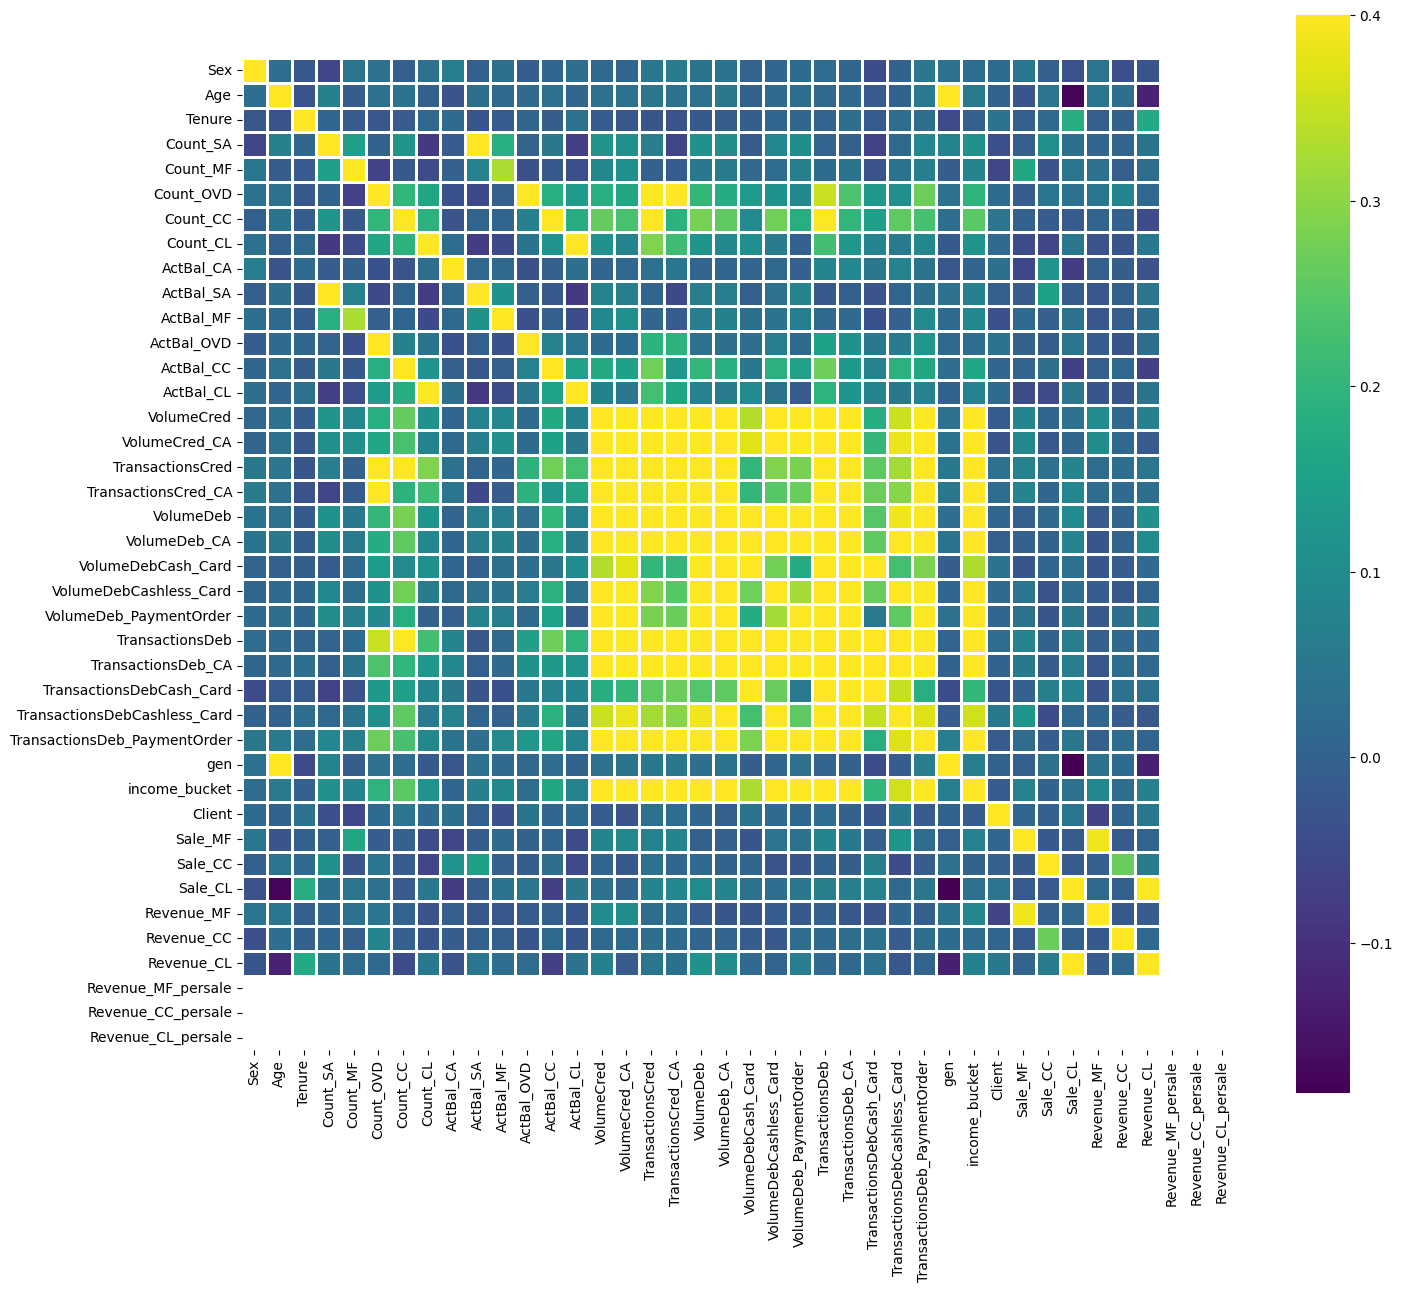

In [470]:
corr = pd.concat([X,y],axis=1).corr()
plt.figure(figsize=(16, 14))
sns.heatmap(corr, vmax=0.4,
            square=True, linewidths=2, cmap='viridis')
plt.savefig("heatmap.png")
plt.show()

In [471]:
# Observations from the correlation matrix
# age is important for Sales CL: the yonger the client the higher the probablity to accept a consumer loan offer
# count cc, ovd and cl are correlated
# ActbAL_CC IS INVERSELY CORRELATED with the revenue/CL CL --> the higher the balance in the Credit Card, the lesslikely the client will go for a Customer Loan
# sale MF and countMF are correlated
# Age is inversely correlated with CL. Young client tends to buy a customer loan
# The product actBalance and Soc_Den tables seem to be more correlated with the target variabels. 
# the Inflow_outflow data is highly cross correlated. 
# the higher the tenure, the more tendensy to accept a loan offer. 
# actBal CL is inversely correlated with Count/bal MF and SA ==> the less saving and funds the client has, the more likely to take a loan. 


## Propensity model 1: Mutual Fund

According to [1] (caracteristic of mututla fund investors in 2020 in the US)
 age, employment status, income, saving, how many other funds they have are important caracteristics to guess if the client will accept a mutual fund offer. The following caracteristic are mensioned in the article:
* age 35 to 65
* in their saving peak
* full time employed
* moderate household income
*	often have several mutual funds
*	focused on retirement saving

[1] https://www.ici.org/doc-server/pdf%3Aper26-09.pdf


In [482]:
target_variable = 'Sale_MF'
Y = y[target_variable]

### Features Importance

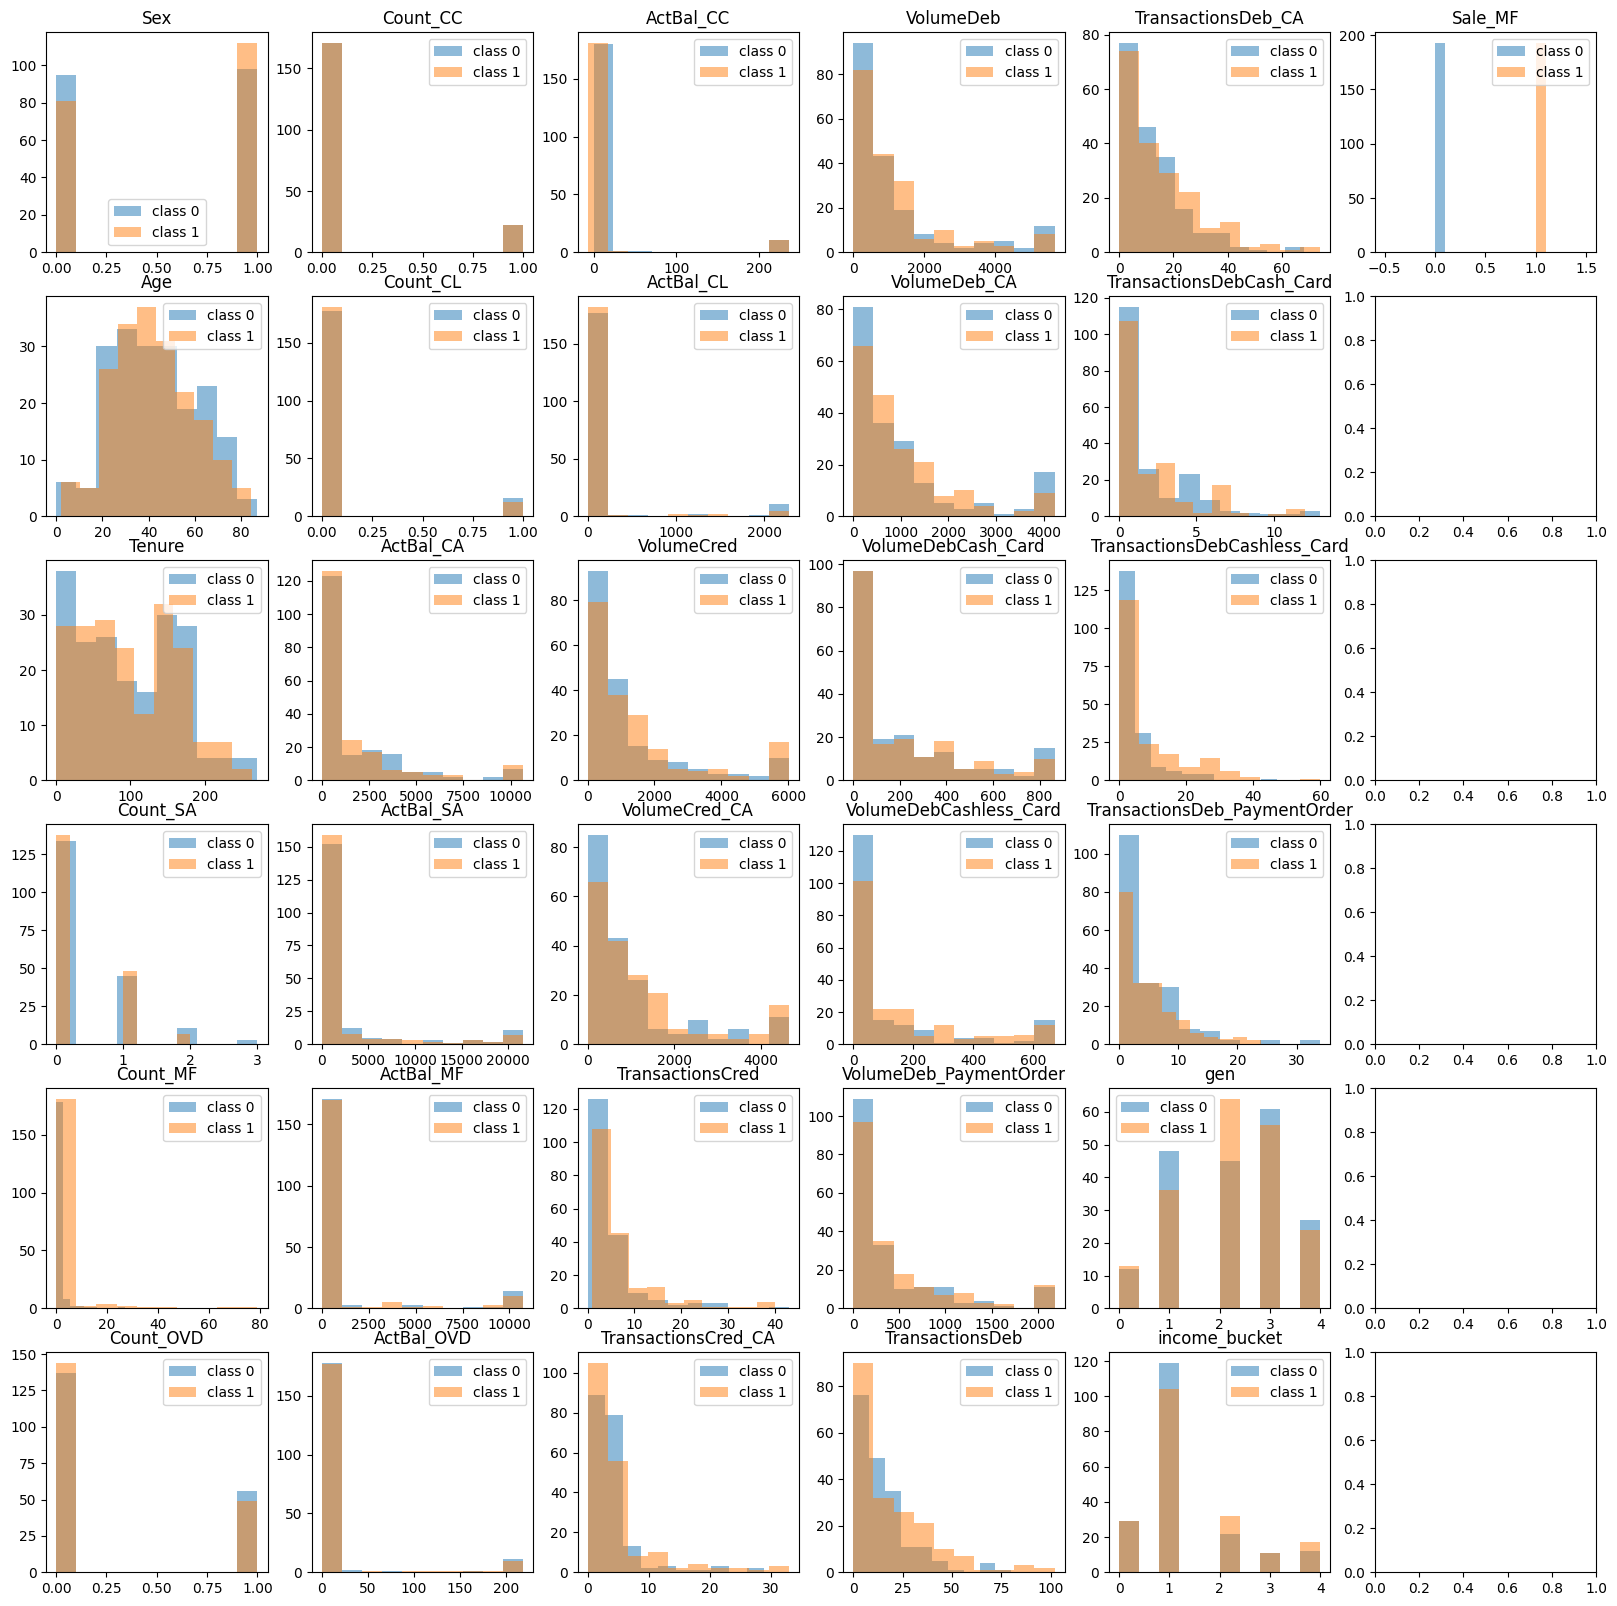

In [473]:
# plot for each feature its correlation with the target
box_plot = False
fig, ax = plt.subplots(6,6,figsize=(20,20))
i=0
#all_features = all_features_NOoutliers
dataset = pd.concat([X,Y],axis=1)
pos = dataset[dataset[target_variable]==1]
neg = dataset[dataset[target_variable]==0][:len(pos)]

for feature in dataset.columns:
    if box_plot:
        ax[i%6,i//6].boxplot([pos[feature],neg[feature]])
    else:
        ax[i%6,i//6].hist(neg[feature],label='class 0',alpha=0.5)#,bins="rice")
        ax[i%6,i//6].hist(pos[feature],label='class 1',alpha=0.5)#,bins="rice")
        ax[i%6,i//6].legend()

    ax[i%6,i//6].set_title(feature)
    i=i+1


In [10]:
# count_CA is always 1 sometimes 2,3,4 accounts. it seems that this is the minor eligibility to be a KBC customer is via a currrent account. I will remove this feature, because of its unsignificant small variability.

# there are age of between 0 and 18. it looks like parents can open a bank account for their children. --> Not to remove
# we can create another column derived from age with minor, young, older, old.


### Features Selection

In [246]:
#feature selection
#manual selection
"""X = X[['Tenure', 'Age', 'TransactionsCred','gen','income_bucket',
       'ActBal_SA', 'Sex', 'TransactionsDebCash_Card', 'Count_MF',
       'ActBal_OVD', 'Count_CA', 'Count_SA', 'ActBal_CL', 'Count_OVD',
       'Count_CC', 'ActBal_MF', 'Count_CL', 'ActBal_CC']]"""


In [483]:
from sklearn.feature_selection import SelectKBest, chi2
SK = SelectKBest(chi2, k=25)
X_t = SK.fit_transform(abs(X), Y)

X_train, X_test, y_train, y_test = train_test_split(X_t, Y, stratify=Y, test_size=0.33, random_state=0)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


## Basic Decision Tree

DecisionTreeClassifier : ROC AUC=0.545
Best Threshold=1.000000, G-Mean=0.516
Best Threshold=0.000000, F-Score=0.465


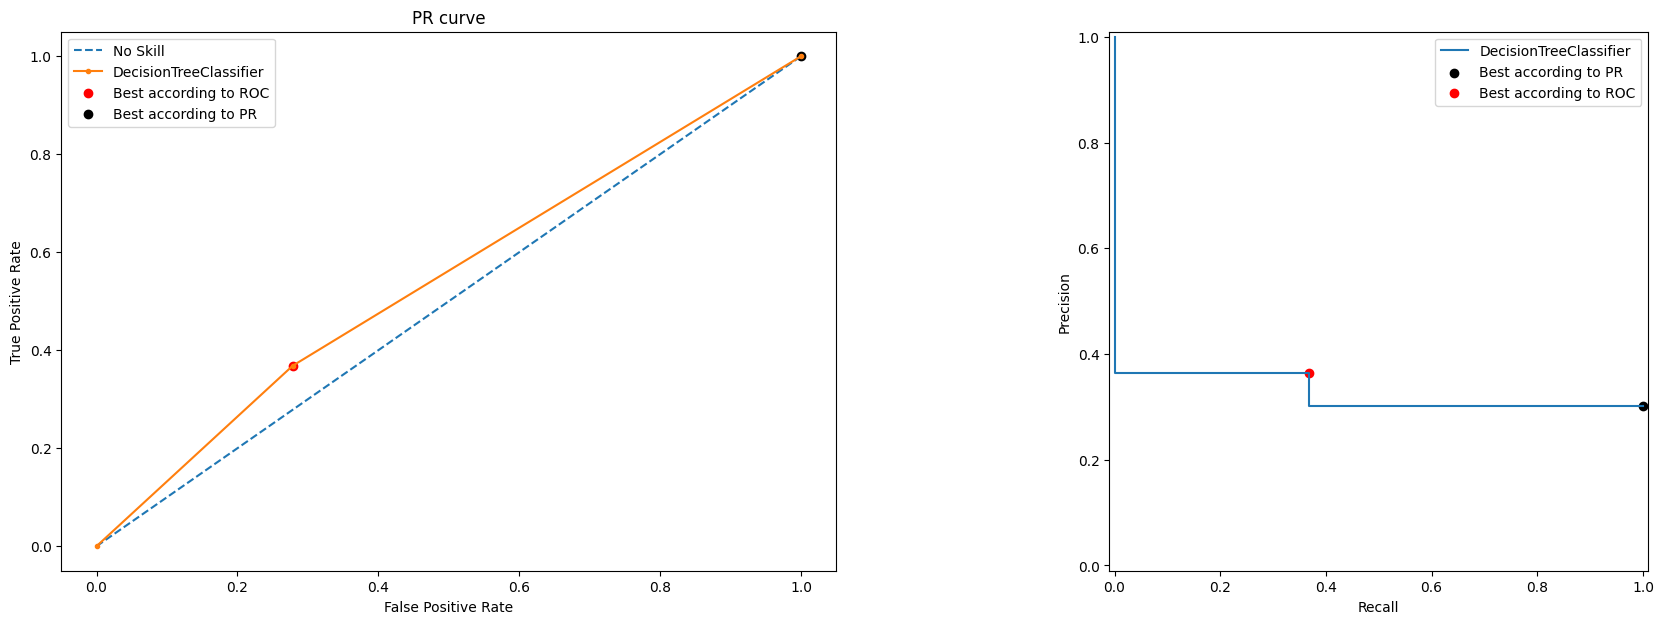

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       219
           1       0.36      0.37      0.37        95

    accuracy                           0.61       314
   macro avg       0.54      0.54      0.54       314
weighted avg       0.62      0.61      0.62       314



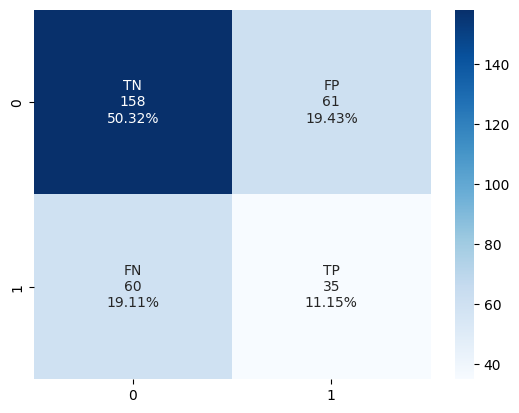

In [305]:
DTC = tree.DecisionTreeClassifier(class_weight='balanced')
DTC = DTC.fit(X_resampled, y_resampled)
y_pred = evaluation_report(DTC,X_test, y_test)


[Text(0.5548469387755102, 0.9285714285714286, 'gen <= 3.5\ngini = 0.5\nsamples = 1016\nvalue = [508, 508]'),
 Text(0.288265306122449, 0.7857142857142857, 'Age <= 19.5\ngini = 0.497\nsamples = 902\nvalue = [419.0, 483.0]'),
 Text(0.15306122448979592, 0.6428571428571429, 'Count_MF <= 37.5\ngini = 0.249\nsamples = 48\nvalue = [41, 7]'),
 Text(0.1326530612244898, 0.5, 'TransactionsDebCash_Card <= 8.5\ngini = 0.223\nsamples = 47\nvalue = [41.0, 6.0]'),
 Text(0.08163265306122448, 0.35714285714285715, 'VolumeDeb <= 1.429\ngini = 0.169\nsamples = 43\nvalue = [39, 4]'),
 Text(0.04081632653061224, 0.21428571428571427, 'VolumeDeb_CA <= 0.893\ngini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.02040816326530612, 0.07142857142857142, '\n  (...)  \n'),
 Text(0.061224489795918366, 0.07142857142857142, '\n  (...)  \n'),
 Text(0.12244897959183673, 0.21428571428571427, 'ActBal_CC <= 178.389\ngini = 0.102\nsamples = 37\nvalue = [35, 2]'),
 Text(0.10204081632653061, 0.07142857142857142, '\n  (...)  \n')

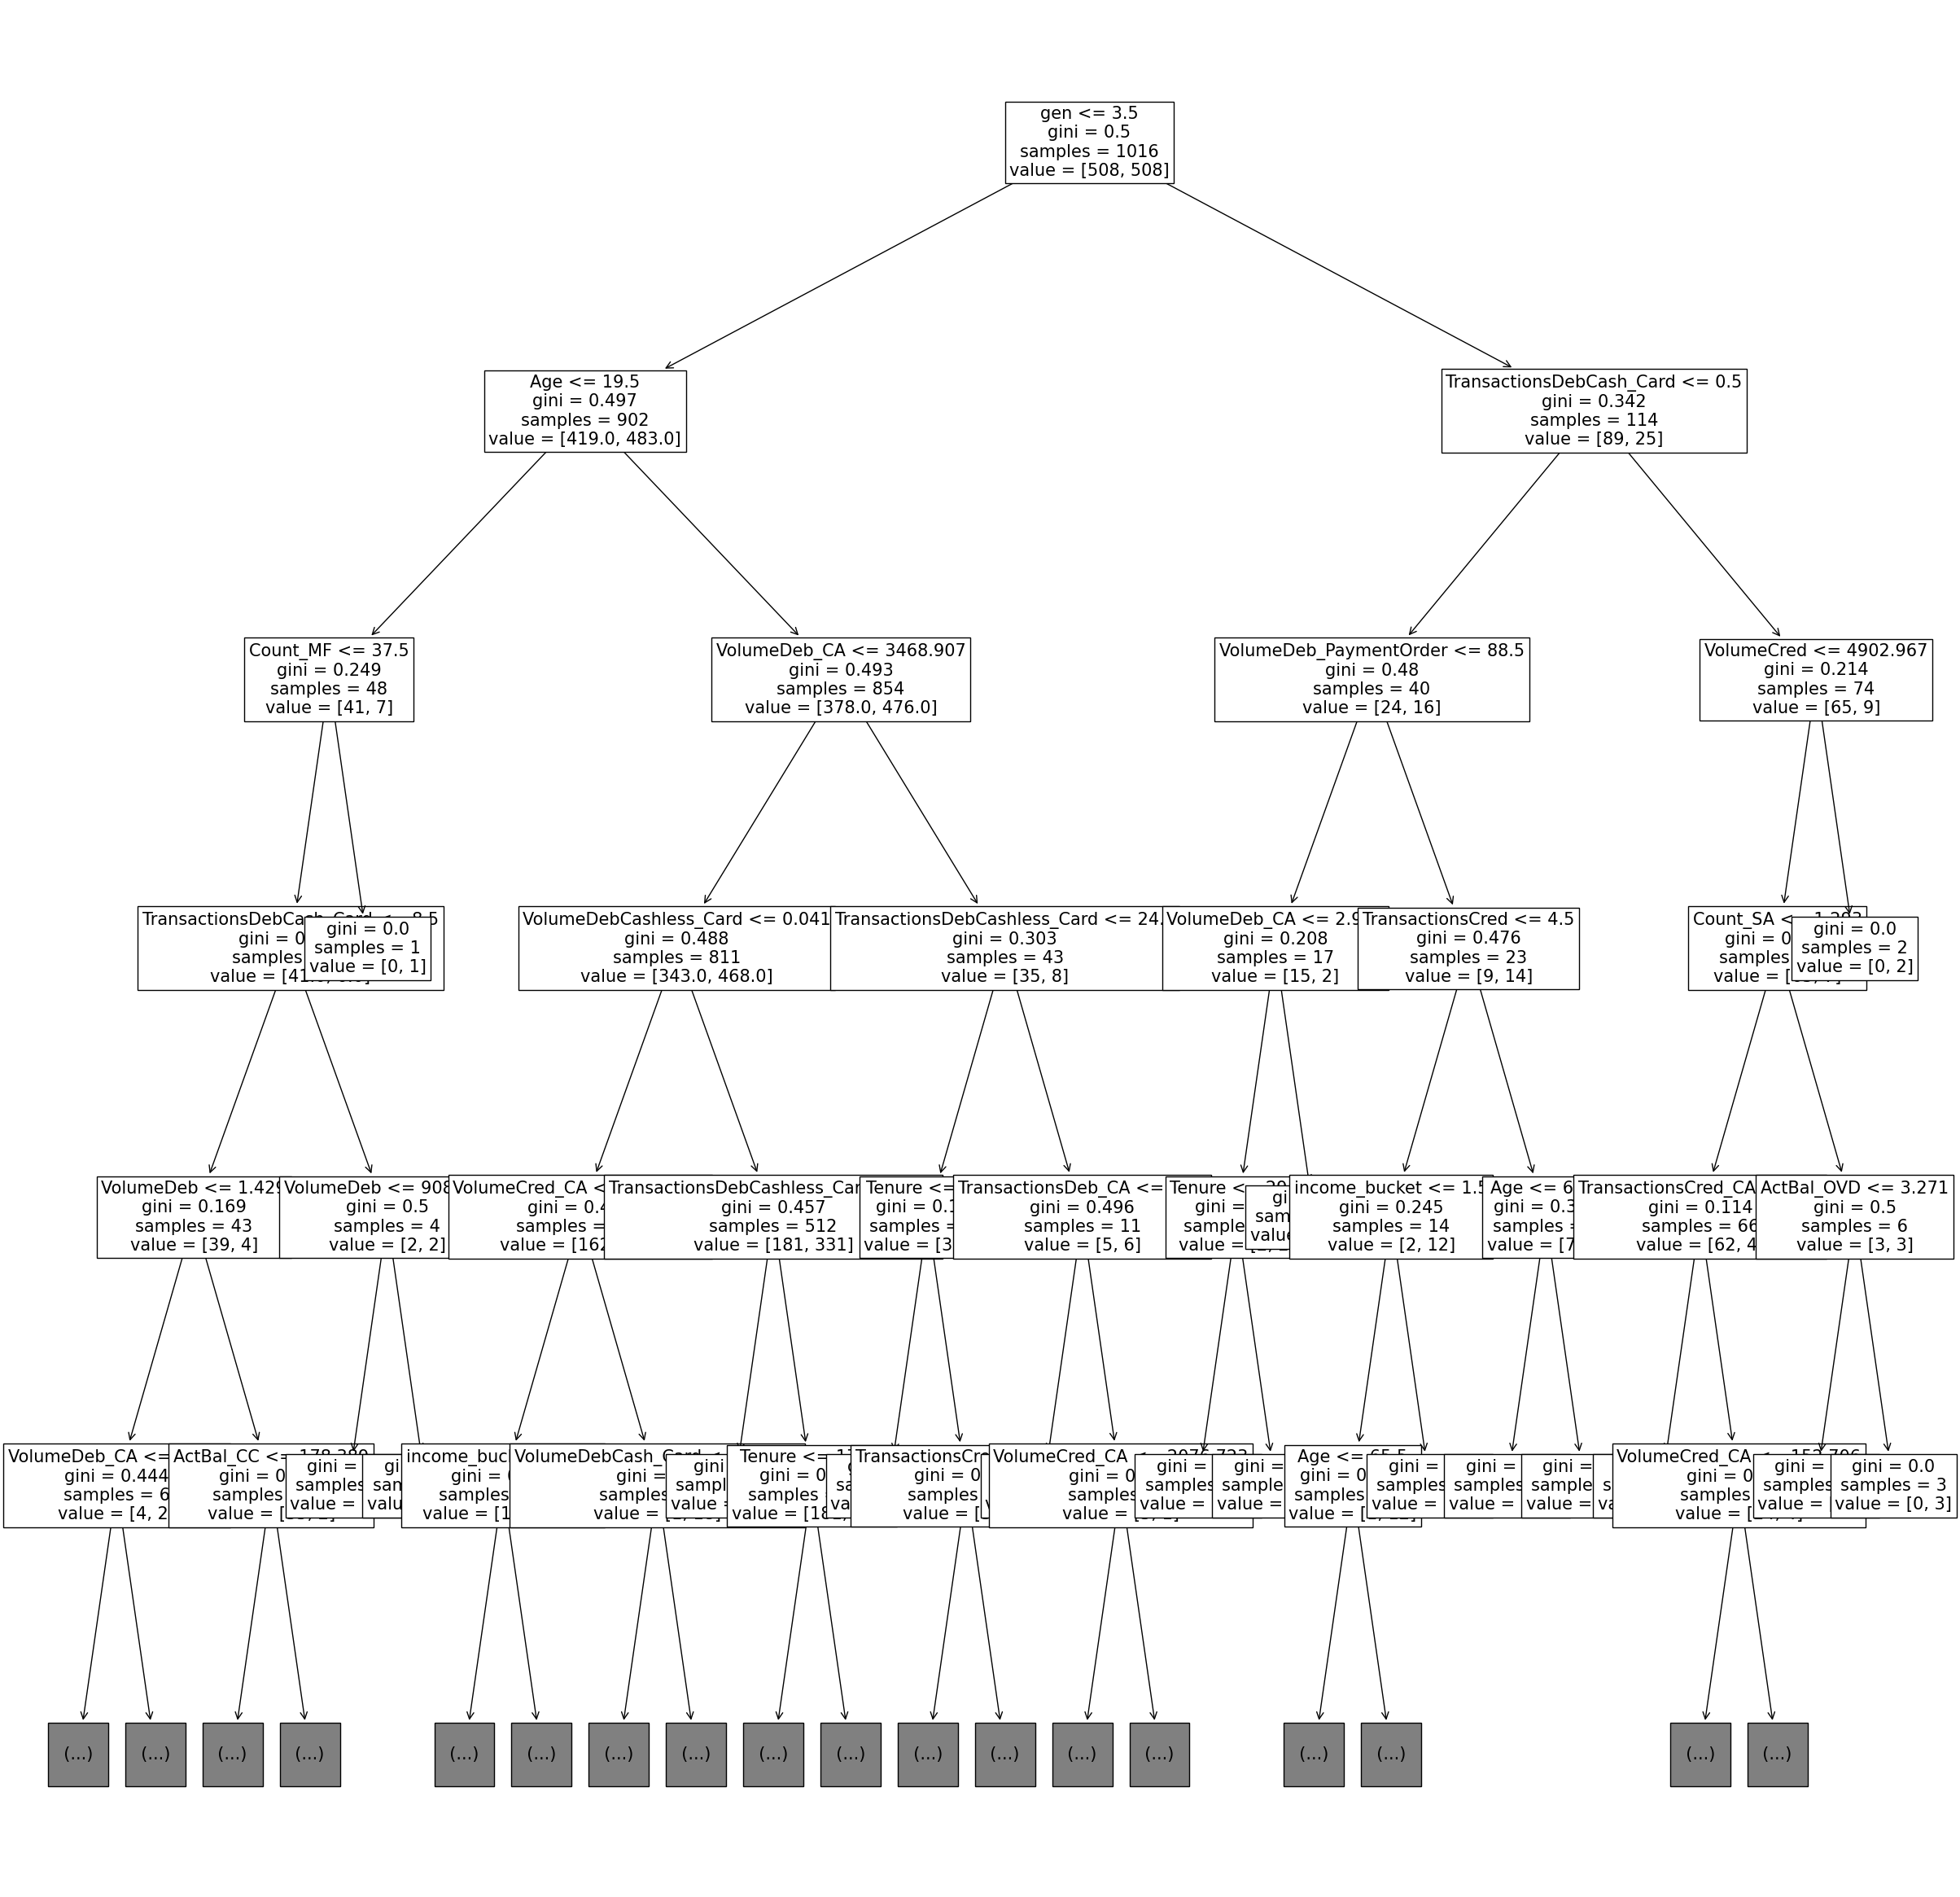

In [139]:
plt.figure(figsize=(30,30))
tree.plot_tree(DTC,max_depth=5, feature_names=features_name, fontsize=15)

## Random Forest

In [140]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt',None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, 1)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#class weight
class_weight = ['balanced',{1:8,0:1}]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': class_weight}
               
forest = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = forest, scoring='f1', param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_resampled, y_resampled)

print(rf_random.best_params_)
rf_best = rf_random.best_estimator_

{'n_estimators': 644, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'bootstrap': True}


Evaluate model


RandomForestClassifier : ROC AUC=0.584
Best Threshold=0.333851, G-Mean=0.571
Best Threshold=0.712733, F-Score=nan


/var/folders/nl/lwjvqp8n6d1_pbcxd44spzyc0000gn/T/ipykernel_18807/1583609279.py:68: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


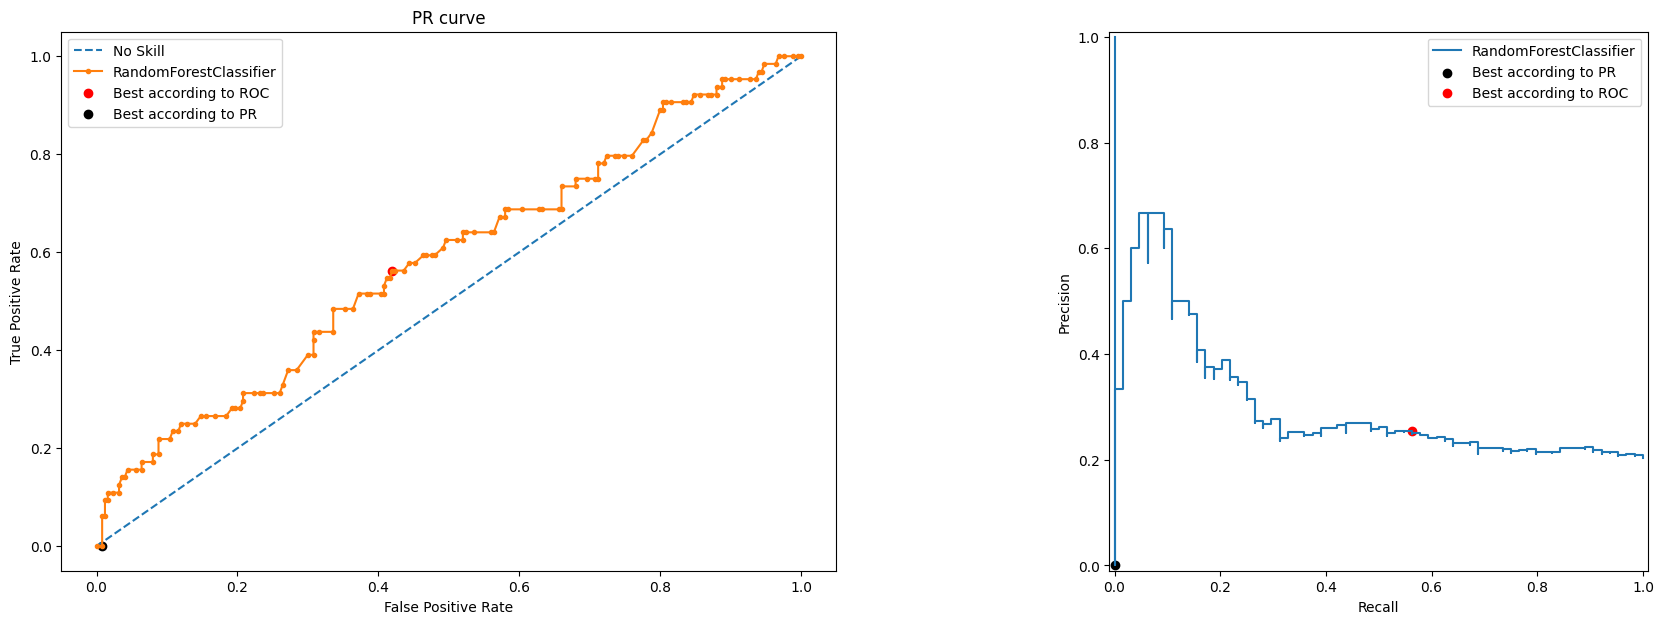

              precision    recall  f1-score   support

           0       0.84      0.58      0.69       250
           1       0.26      0.56      0.35        64

    accuracy                           0.58       314
   macro avg       0.55      0.57      0.52       314
weighted avg       0.72      0.58      0.62       314



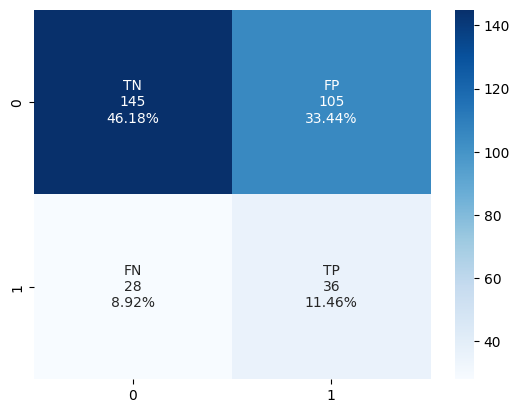

In [141]:
y_pred = evaluation_report(rf_best,X_test,y_test, best= 'ROC')

## Logistic Regression

In [484]:
# create a pipline
pca = PCA()
std_slc = StandardScaler()
logistic_Reg = LogisticRegression()
pipe = Pipeline(steps=[('slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', logistic_Reg)])

### components of the PCA
n_components = list(range(1,X_t.shape[1]+1,1))
### LR hyperparams
C = np.logspace(-4, 4, 50)
penalty = ['l2']
solver=['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
class_weight = ['balanced',{1:8,0:1},None]
# Create the random grid
random_grid = {'pca__n_components': n_components,
               'logistic_Reg__C': C,
               'logistic_Reg__solver': solver,
               'logistic_Reg__penalty': penalty,
               'logistic_Reg__class_weight': class_weight}
               
LogReg = RandomizedSearchCV(estimator = pipe, scoring='precision', param_distributions = random_grid, n_iter = 300, cv = 5, random_state=42, n_jobs = -1)
# Fit the random search model
LogReg.fit(X_resampled, y_resampled)
print(LogReg.best_params_)
lr_best = LogReg.best_estimator_

{'pca__n_components': 24, 'logistic_Reg__solver': 'liblinear', 'logistic_Reg__penalty': 'l2', 'logistic_Reg__class_weight': None, 'logistic_Reg__C': 1.7575106248547894}


Pipeline : ROC AUC=0.624
Best Threshold=0.567801, G-Mean=0.605
Best Threshold=0.567801, F-Score=0.411


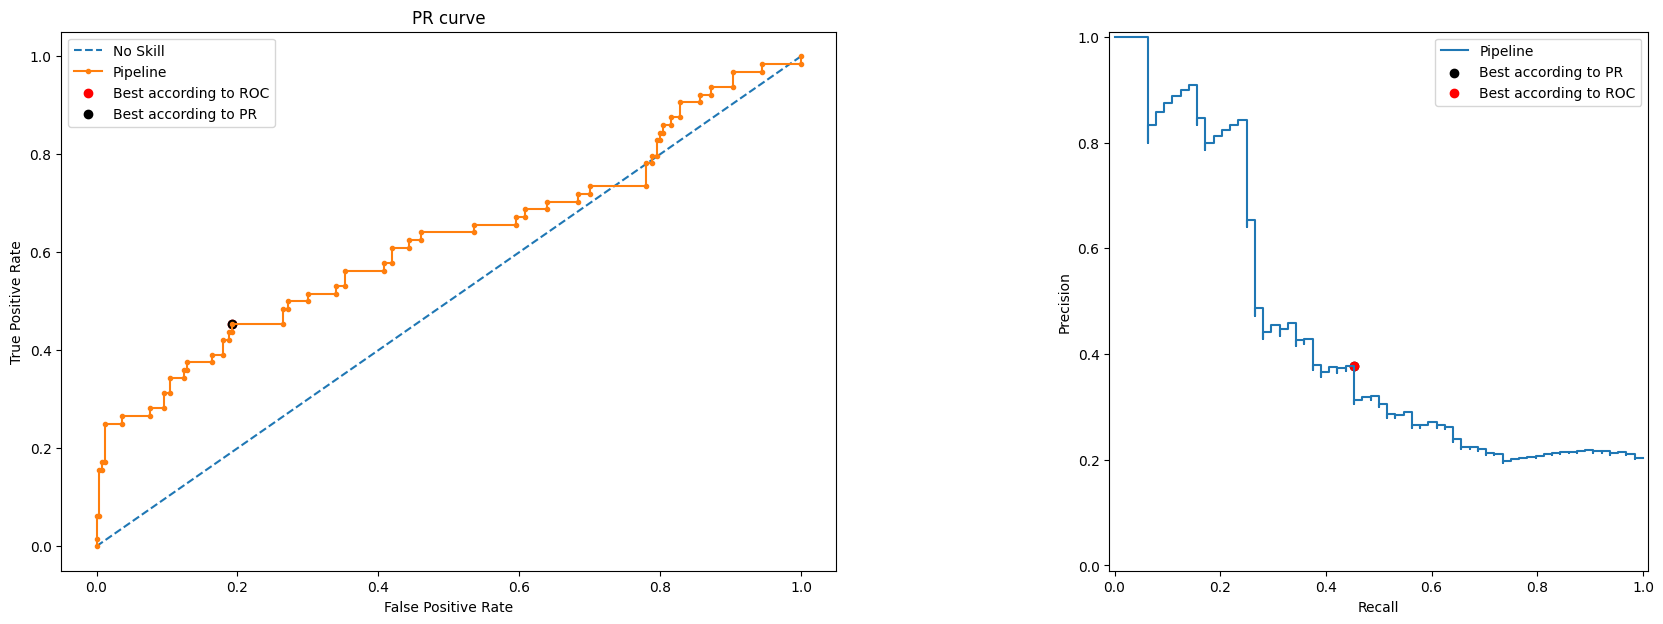

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       250
           1       0.38      0.45      0.41        64

    accuracy                           0.74       314
   macro avg       0.61      0.63      0.62       314
weighted avg       0.76      0.74      0.74       314



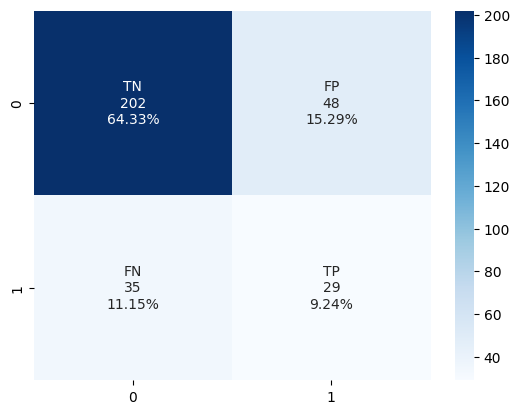

In [485]:
y_pred = evaluation_report(lr_best,X_test,y_test, best= 'ROC')

## XGboost

In [209]:
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

xgb_model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_model.fit(X_resampled, y_resampled)

y_pred = xgb_model.predict(X_test)



XGBClassifier : ROC AUC=0.580
Best Threshold=0.042403, G-Mean=0.589
Best Threshold=0.987841, F-Score=nan


/var/folders/nl/lwjvqp8n6d1_pbcxd44spzyc0000gn/T/ipykernel_18807/1583609279.py:68: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


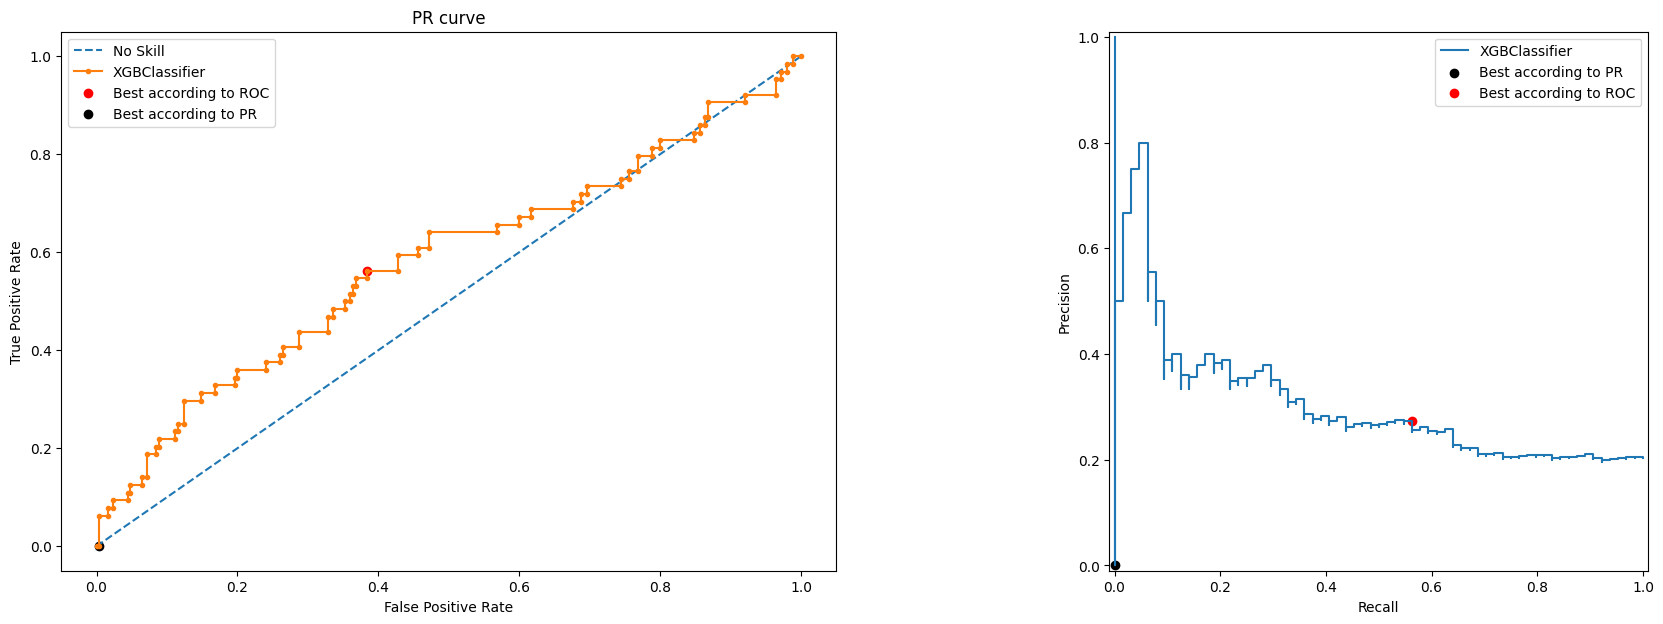

              precision    recall  f1-score   support

           0       0.85      0.62      0.71       250
           1       0.27      0.56      0.37        64

    accuracy                           0.61       314
   macro avg       0.56      0.59      0.54       314
weighted avg       0.73      0.61      0.64       314



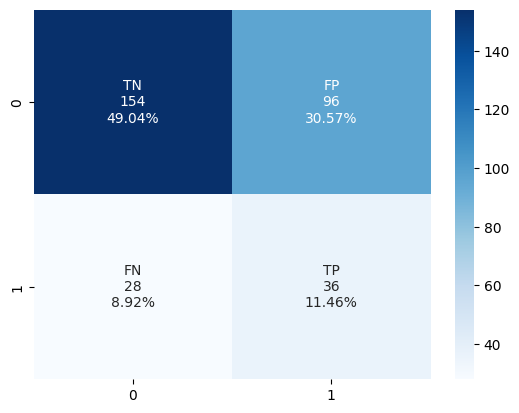

In [210]:
y_pred = evaluation_report(xgb_model, X_test,y_test)

In [211]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_resampled, y_resampled)
print(gsearch1.best_params_)
best_xgb = gsearch1.best_estimator_

{'max_depth': 9, 'min_child_weight': 1}


XGBClassifier : ROC AUC=0.608
Best Threshold=0.147757, G-Mean=0.604
Best Threshold=0.147757, F-Score=0.388


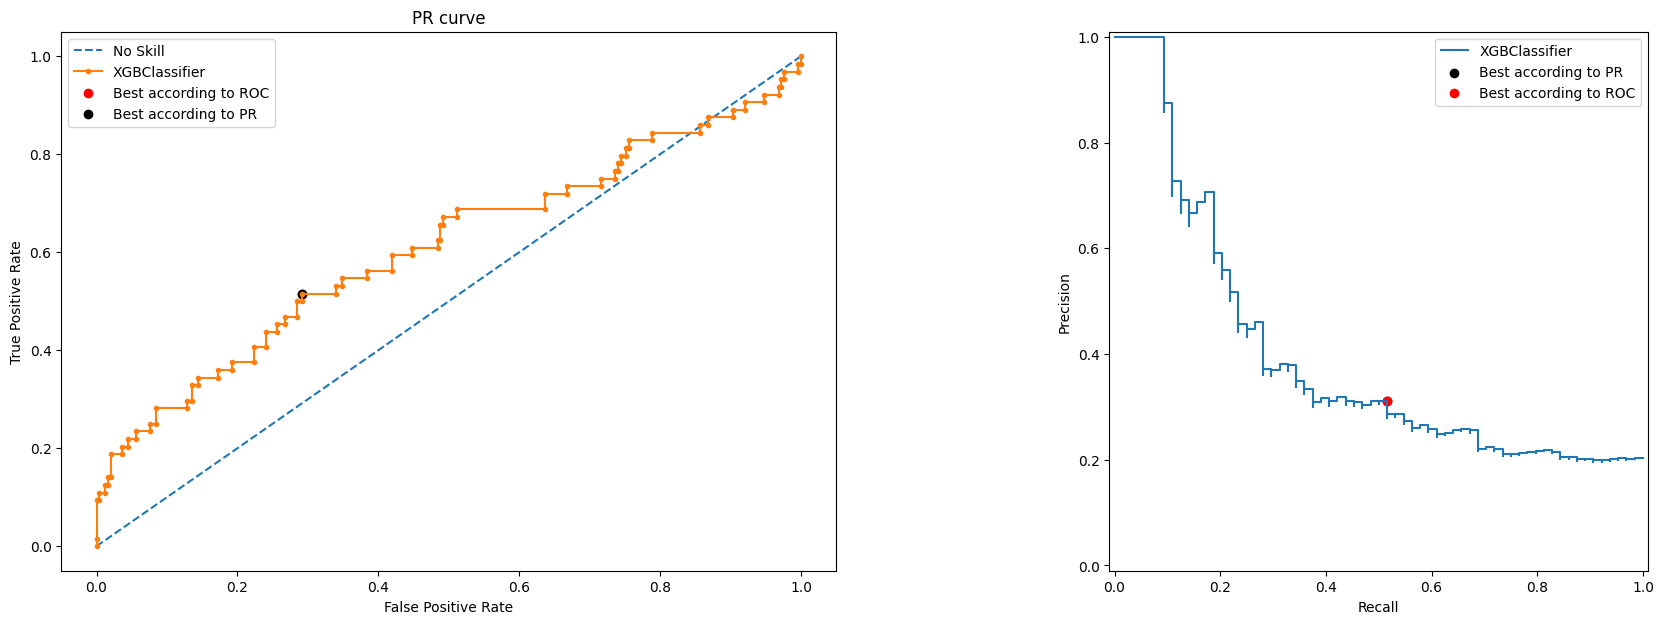

              precision    recall  f1-score   support

           0       0.85      0.71      0.77       250
           1       0.31      0.52      0.39        64

    accuracy                           0.67       314
   macro avg       0.58      0.61      0.58       314
weighted avg       0.74      0.67      0.69       314



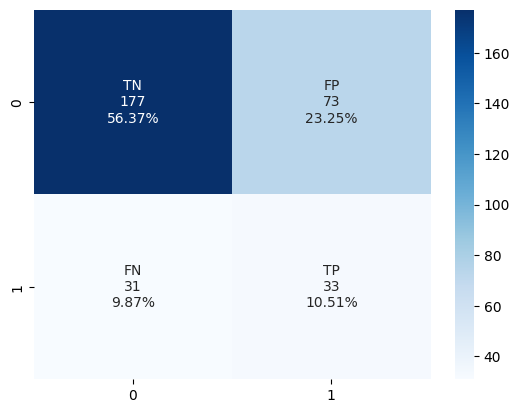

In [213]:
y_pred = evaluation_report(best_xgb, X_test,y_test, best='PR')

In [193]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel ("Xgboost Feature Importance" )

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### Evaluation

DecisionTreeClassifier : ROC AUC=0.518
Best Threshold=1.000000, G-Mean=0.469
Best Threshold=0.000000, F-Score=0.339
Pipeline : ROC AUC=0.573
Best Threshold=0.477093, G-Mean=0.552
Best Threshold=0.193253, F-Score=0.356
RandomForestClassifier : ROC AUC=0.584
Best Threshold=0.333851, G-Mean=0.571
Best Threshold=0.712733, F-Score=nan
XGBClassifier : ROC AUC=0.556
Best Threshold=0.055043, G-Mean=0.551
Best Threshold=0.000267, F-Score=0.350


/var/folders/nl/lwjvqp8n6d1_pbcxd44spzyc0000gn/T/ipykernel_18807/1583609279.py:68: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


XGBClassifier : ROC AUC=0.560
Best Threshold=0.198859, G-Mean=0.539
Best Threshold=0.048327, F-Score=0.365


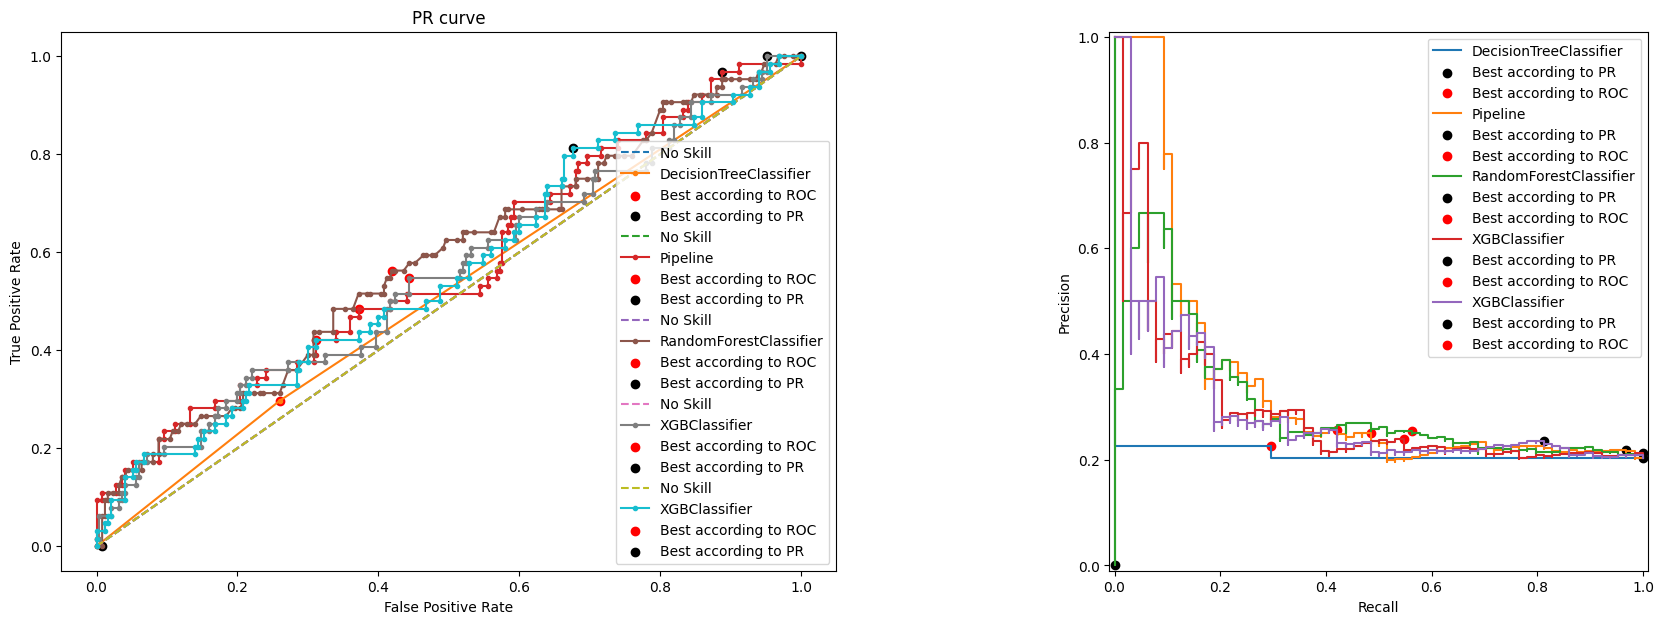

In [154]:
models_list = [DTC, lr_best, rf_best, xgb_model, best_xgb]
evaluation_report_all(models_list,X_test,y_test)

In [ ]:
#==> logistics regression is the winning for mutual fund with threshold = 0.57

In [486]:
#eval
eval_t = SK.transform(abs(eval).drop('Client', axis=1))
y_proba_MF = lr_best.predict_proba(eval_t)[:,1]
POS_MF = y_proba_MF>=0.6
clients_pos_MF = eval.Client[POS_MF].values
clients_pos_MF

array([   3,   18,   25,   30,   39,   57,   64,   91,  109,  121,  146,
        150,  153,  154,  155,  188,  211,  224,  231,  233,  237,  239,
        265,  283,  299,  340,  354,  362,  375,  389,  426,  427,  430,
        431,  432,  476,  484,  531,  559,  565,  579,  583,  607,  637,
        668,  677,  697,  708,  710,  726,  759,  766,  779,  785,  786,
        817,  830,  868,  878,  889,  891,  910,  929,  933,  940,  958,
        968,  983,  991, 1002, 1007, 1008, 1057, 1082, 1088, 1093, 1095,
       1102, 1119, 1129, 1148, 1156, 1181, 1183, 1187, 1211, 1225, 1226,
       1229, 1257, 1332, 1349, 1398, 1416, 1422, 1424, 1435, 1440, 1466,
       1468, 1480, 1482, 1498, 1504, 1516, 1518, 1569, 1603])

In [487]:
print(len(clients_pos_MF), 'clients have higher propensity to buy mutual fund')

108 clients have higher propensity to buy mutual fund


## Propensity model2: credit card


In [488]:
target_variable = 'Sale_CC'
Y = y[target_variable]

from sklearn.feature_selection import SelectKBest, chi2
SK = SelectKBest(chi2, k=25)
X_t = SK.fit_transform(abs(X), Y)

X_train, X_test, y_train, y_test = train_test_split(X_t, Y, stratify=Y, test_size=0.33, random_state=0)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

### models

In [489]:
# create a pipline
pca = PCA()
std_slc = StandardScaler()
logistic_Reg = LogisticRegression()
pipe = Pipeline(steps=[('slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', logistic_Reg)])

### components of the PCA
n_components = list(range(1,X_t.shape[1]+1,1))
### LR hyperparams
C = np.logspace(-4, 4, 50)
penalty = ['l2']
solver=['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
class_weight = ['balanced',{1:8,0:1},None]
# Create the random grid
random_grid = {'pca__n_components': n_components,
               'logistic_Reg__C': C,
               'logistic_Reg__solver': solver,
               'logistic_Reg__penalty': penalty,
               'logistic_Reg__class_weight': class_weight}
               
LogReg = RandomizedSearchCV(estimator = pipe, scoring='precision', param_distributions = random_grid, n_iter = 300, cv = 5, random_state=42, n_jobs = -1)
# Fit the random search model
LogReg.fit(X_resampled, y_resampled)
print(LogReg.best_params_)
lr_best = LogReg.best_estimator_

{'pca__n_components': 25, 'logistic_Reg__solver': 'newton-cholesky', 'logistic_Reg__penalty': 'l2', 'logistic_Reg__class_weight': 'balanced', 'logistic_Reg__C': 159.98587196060572}


Pipeline : ROC AUC=0.596
Best Threshold=0.421010, G-Mean=0.564
Best Threshold=0.323530, F-Score=0.430


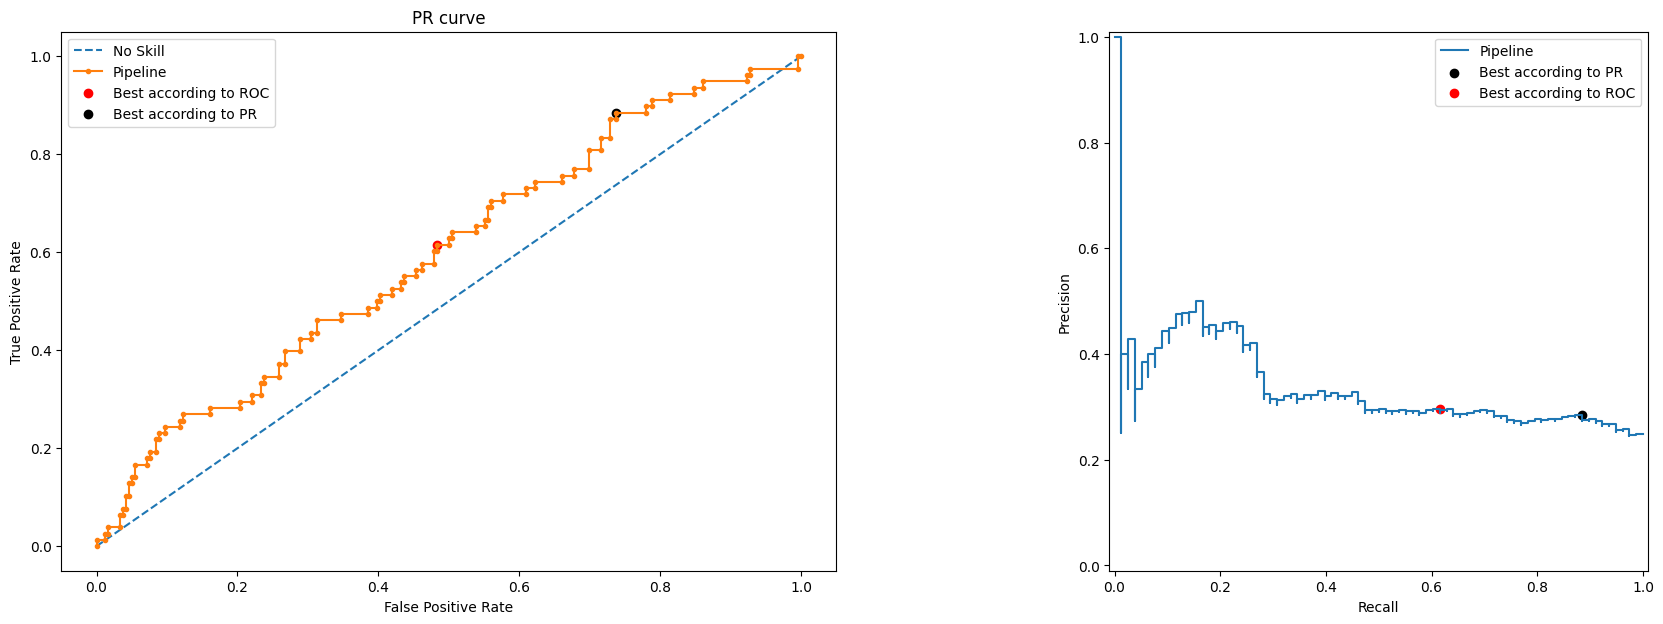

              precision    recall  f1-score   support

           0       0.80      0.52      0.63       236
           1       0.30      0.62      0.40        78

    accuracy                           0.54       314
   macro avg       0.55      0.57      0.51       314
weighted avg       0.68      0.54      0.57       314



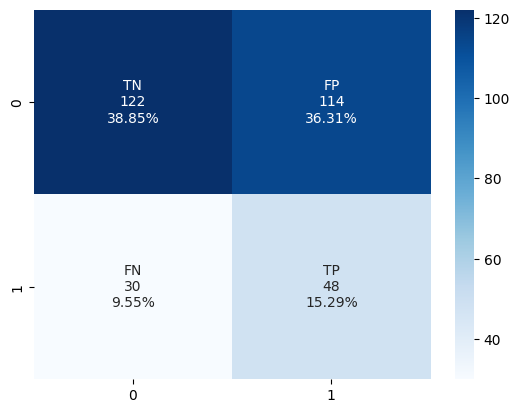

In [490]:
y_pred = evaluation_report(lr_best,X_test,y_test, best= 'ROC')

### Validate

In [491]:
eval_t = SK.transform(abs(eval).drop('Client', axis=1))
y_proba_cc = lr_best.predict_proba(eval_t)[:,1]
POS_cc = y_proba_cc>=0.6
clients_pos_cc = eval.Client[POS_cc].values
clients_pos_cc

array([   5,    9,   16,   19,   32,   51,   63,   94,   98,  104,  115,
        125,  126,  128,  145,  151,  152,  153,  168,  196,  197,  201,
        206,  217,  228,  243,  289,  312,  336,  345,  347,  350,  352,
        353,  356,  359,  362,  373,  381,  382,  401,  409,  454,  488,
        496,  505,  516,  523,  532,  535,  540,  545,  571,  587,  592,
        633,  640,  668,  685,  697,  701,  727,  748,  760,  772,  778,
        779,  780,  785,  791,  797,  813,  851,  853,  876,  886,  902,
        931,  951,  965,  978,  996, 1002, 1010, 1037, 1051, 1069, 1076,
       1090, 1110, 1112, 1120, 1124, 1127, 1133, 1136, 1138, 1200, 1207,
       1227, 1240, 1241, 1249, 1252, 1260, 1262, 1271, 1278, 1280, 1300,
       1304, 1314, 1339, 1349, 1365, 1366, 1374, 1385, 1410, 1414, 1419,
       1443, 1445, 1449, 1474, 1487, 1489, 1491, 1503, 1508, 1526, 1530,
       1543, 1550, 1588, 1597, 1598, 1610])

In [492]:
print(len(clients_pos_cc), 'clients have higher propensity to buy mutual fund')

138 clients have higher propensity to buy mutual fund


## Propensity model 3: Customer lOAN


In [493]:
target_variable = 'Sale_CL'
Y = y[target_variable]

from sklearn.feature_selection import SelectKBest, chi2
SK = SelectKBest(chi2, k=25)
X_t = SK.fit_transform(abs(X), Y)

X_train, X_test, y_train, y_test = train_test_split(X_t, Y, stratify=Y, test_size=0.33, random_state=0)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [494]:
# create a pipline
pca = PCA()
std_slc = StandardScaler()
logistic_Reg = LogisticRegression()
pipe = Pipeline(steps=[('slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', logistic_Reg)])

### components of the PCA
n_components = list(range(1,X_t.shape[1]+1,1))
### LR hyperparams
C = np.logspace(-4, 4, 50)
penalty = ['l2']
solver=['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
class_weight = ['balanced',{1:8,0:1},None]
# Create the random grid
random_grid = {'pca__n_components': n_components,
               'logistic_Reg__C': C,
               'logistic_Reg__solver': solver,
               'logistic_Reg__penalty': penalty,
               'logistic_Reg__class_weight': class_weight}
               
LogReg = RandomizedSearchCV(estimator = pipe, scoring='precision', param_distributions = random_grid, n_iter = 300, cv = 5, random_state=42, n_jobs = -1)
# Fit the random search model
LogReg.fit(X_resampled, y_resampled)
print(LogReg.best_params_)
lr_best = LogReg.best_estimator_

{'pca__n_components': 22, 'logistic_Reg__solver': 'lbfgs', 'logistic_Reg__penalty': 'l2', 'logistic_Reg__class_weight': 'balanced', 'logistic_Reg__C': 6866.488450042998}


Pipeline : ROC AUC=0.624
Best Threshold=0.572405, G-Mean=0.607
Best Threshold=0.198983, F-Score=0.477


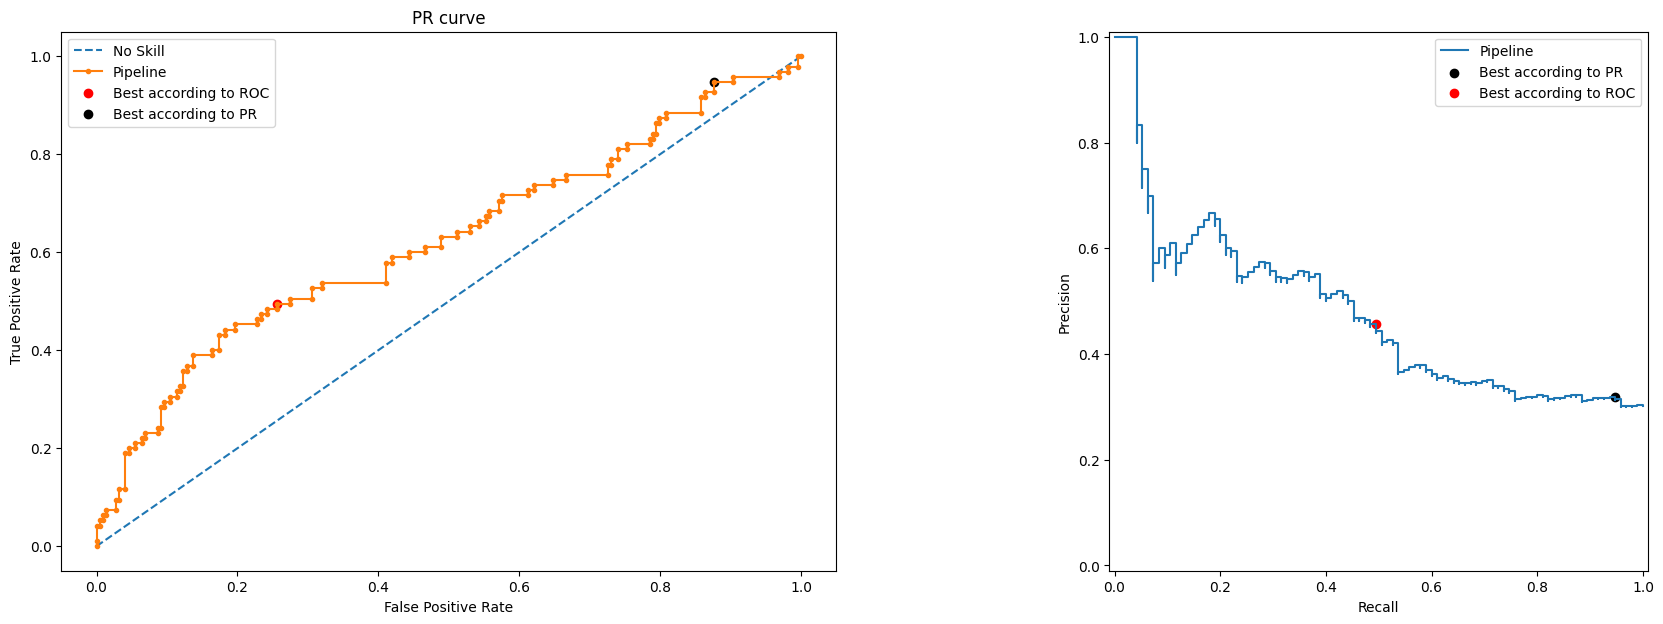

              precision    recall  f1-score   support

           0       0.77      0.74      0.76       219
           1       0.46      0.49      0.47        95

    accuracy                           0.67       314
   macro avg       0.61      0.62      0.62       314
weighted avg       0.68      0.67      0.67       314



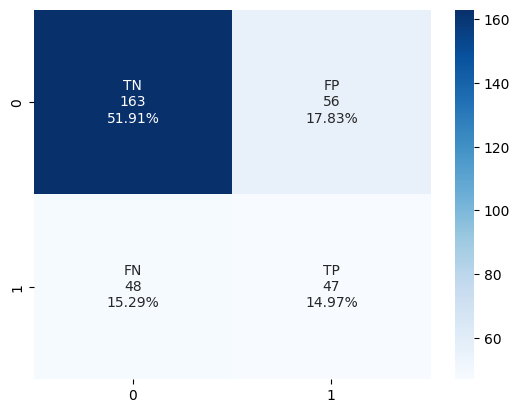

In [495]:
y_pred = evaluation_report(lr_best,X_test,y_test, best= 'ROC')

In [496]:
#eval
eval_t = SK.transform(abs(eval).drop('Client', axis=1))
y_proba_CL = lr_best.predict_proba(eval_t)[:,1]
POS_CL = y_proba_CL>=0.7
clients_pos_CL = eval.Client[POS_CL].values
clients_pos_CL

array([  41,   57,   61,   89,  119,  153,  164,  168,  217,  231,  235,
        239,  240,  261,  274,  293,  299,  307,  314,  325,  329,  331,
        342,  350,  382,  394,  403,  431,  458,  474,  485,  490,  496,
        498,  504,  511,  516,  524,  528,  530,  531,  535,  541,  562,
        566,  595,  665,  677,  699,  706,  710,  727,  731,  750,  779,
        781,  811,  817,  828,  829,  834,  852,  862,  878,  889,  948,
        965,  967,  976,  978, 1013, 1031, 1049, 1050, 1063, 1064, 1082,
       1096, 1107, 1122, 1123, 1192, 1211, 1226, 1237, 1240, 1300, 1321,
       1341, 1343, 1349, 1356, 1358, 1360, 1365, 1416, 1424, 1443, 1455,
       1474, 1516, 1543, 1597, 1599, 1611])

In [497]:
print(len(clients_pos_CL), 'clients have higher propensity to buy mutual fund')

105 clients have higher propensity to buy mutual fund


## Which clients are to be targeted with which offer? General description.


The bank has capacity to contact only 15 pct. of the clients (cca 100 people) with a marketing
offer and each client can be targeted only once.
* We target the clients that have higher probability to go for an offer and genarte the highest revenue.
* We estimate the revenues generated with each offer by the median of the distribution
* Multiply probability of prediction with the median revenue, to get both factors into account
* for clients that are selected by both offers, we take the maximum revenue*proba offer
* we sort revenue*proba and take the last 100 clients
* We assign the offer to each client.

(array([915.,  11.,  11.,   6.,   3.,   2.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.        ,  11.02441071,  22.04882143,  33.07323214,
         44.09764286,  55.12205357,  66.14646429,  77.170875  ,
         88.19528571,  99.21969643, 110.24410714, 121.26851786,
        132.29292857, 143.31733929, 154.34175   , 165.36616071,
        176.39057143, 187.41498214, 198.43939286, 209.46380357,
        220.48821429]),
 <BarContainer object of 20 artists>)

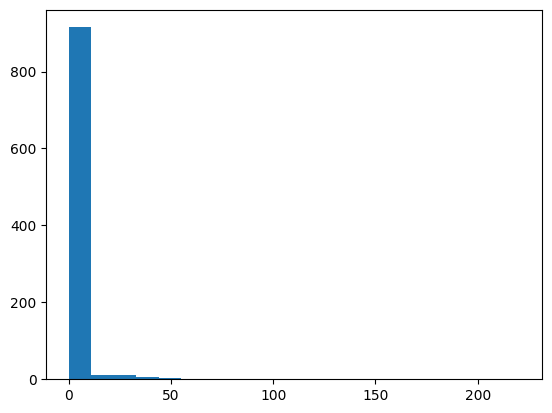

In [343]:
plt.hist(y['Revenue_MF'],bins=20)

In [498]:
y = y.replace(0,np.nan).dropna()
median_rev_MF = y.Revenue_MF.median()
median_rev_CL = y.Revenue_CL.median()
median_rev_CC = y.Revenue_CC.median()
print(median_rev_MF, median_rev_CC, median_rev_CL)

6.917857142857143 3.2151785714285714 12.97625


In [499]:
eval['proba_rev_cc'] = y_proba_cc*median_rev_CC
eval.loc[~eval.Client.isin(clients_pos_cc),'proba_rev_cc'] = 0
eval['proba_rev_MF'] = y_proba_MF*median_rev_MF
eval.loc[~eval.Client.isin(clients_pos_MF),'proba_rev_MF'] = 0

eval['proba_rev_CL'] = y_proba_CL*median_rev_CL
eval.loc[~eval.Client.isin(clients_pos_CL),'proba_rev_CL'] = 0


In [500]:
df = eval[['proba_rev_cc','proba_rev_MF','proba_rev_CL']]
df = df.replace(0,np.nan).dropna(how='all')

In [501]:
print(len(df),'unique client can be targeted with an offer')

306 unique client can be targeted with an offer


In [502]:
client_list = df.max(axis=1).sort_values()[-100:].index.values
print('these are the 100 clients to be targetted with an offer  ', client_list)

these are the 100 clients to be targetted with an offer   [1103  947  270 1570 1029 1515 1398  295  231 1582   40  385 1012  149
  995  714 1102  584  164  289 1295  555 1568  524 1044  551 1030  873
  373 1213  530  465  736  449  694   85 1390  796 1330  818 1334  335
 1447 1274  517  718   55  502  115 1332  519 1062  481  227  687  765
 1087  931  495 1317  257  422 1170  846   58  394  476  665  836  767
  520 1187  309  213 1076  235  813  319 1489  323 1417  160  698  862
  513  325  236  506  653  487 1428  949  814 1043  960 1323 1339  343
 1216 1202]


In [503]:
df_f = df.loc[client_list]
l =[]
for client in df_f.index:

    if df_f.loc[client].argmax() ==2:
        l.append('CL')
    elif df_f.loc[client].argmax() ==1:
        l.append('MF')
    elif df_f.loc[client].argmax() ==0:
        l.append('CC')
df_f['offre'] = l

In [504]:
df_f

,proba_rev_cc,proba_rev_MF,proba_rev_CL,offre
1103,NaN,NaN,9.226226,CL
947,2.286103,NaN,9.260814,CL
270,NaN,NaN,9.283476,CL
1570,NaN,NaN,9.340338,CL
1029,NaN,NaN,9.343513,CL
...,...,...,...,...
1323,2.583651,4.171316,11.778831,CL
1339,2.639062,NaN,11.940357,CL
343,2.014857,NaN,11.988925,CL
1216,1.982160,NaN,12.119789,CL


## What would be the expected revenue based on your strategy?

In [505]:
df_f.offre.value_counts()

offre
CL    100
Name: count, dtype: int64

In [506]:
print('expected revenue is', 100*median_rev_CL)

expected revenue is 1297.625
